## GLENS analysis - Climate Velocity

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from windspharm.xarray import VectorWind
import metpy.calc as mpcalc
from metpy.units import units
from scipy import stats
import nc_time_axis
import cf_xarray 
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib as mpl

### Define file paths, variables

file paths

In [2]:
ctrl_lnd_path = '/glade/scratch/kdagon/GLENS/control/lnd/'
fdbk_lnd_path = '/glade/scratch/kdagon/GLENS/feedback/lnd/'
ctrl_atm_path = '/glade/scratch/kdagon/GLENS/control/atm/'
fdbk_atm_path = '/glade/scratch/kdagon/GLENS/feedback/atm/'

set variable(s) of interest

In [3]:
var = 'TSA'
var_atm = 'TS'

define variable path(s)

In [4]:
ctrl_lnd_path_var = ctrl_lnd_path+var+'/'
fdbk_land_path_var = fdbk_lnd_path+var+'/'
ctrl_atm_path_var = ctrl_atm_path+var_atm+'/'
fdbk_atm_path_var = fdbk_atm_path+var_atm+'/'

### Read in single ensemble members

set input file

In [ ]:
# start with 001 as an example
ctrl_lnd_file_1 = 'b.e15.B5505C5WCCML45BGCR.f09_g16.control.001.clm2.h0.'+var+'.201001-201912.nc'
ctrl_lnd_file_2 = 'b.e15.B5505C5WCCML45BGCR.f09_g16.control.001.clm2.h0.'+var+'.202001-202912.nc'
ctrl_atm_file = 'b.e15.B5505C5WCCML45BGCR.f09_g16.control.001.cam.h0.'+var_atm+'.201001-201912.nc'

decode_times=False to adjust time variable

In [ ]:
ctrl_lnd_var_1 = xr.open_dataset(ctrl_lnd_path_var+ctrl_lnd_file_1, decode_times=False)
ctrl_lnd_var_2 = xr.open_dataset(ctrl_lnd_path_var+ctrl_lnd_file_2, decode_times=False)
ctrl_atm_var = xr.open_dataset(ctrl_atm_path_var+ctrl_atm_file, decode_times=False)

compute new time axis using time bounds

In [ ]:
attrs = ctrl_lnd_var_1.time.attrs.copy()
ctrl_lnd_var_1 = ctrl_lnd_var_1.assign_coords(time=ctrl_lnd_var_1.time_bounds.mean('hist_interval'))
ctrl_lnd_var_1.time.attrs = attrs
ctrl_lnd_var_1 = xr.decode_cf(ctrl_lnd_var_1)

In [ ]:
attrs = ctrl_lnd_var_2.time.attrs.copy()
ctrl_lnd_var_2 = ctrl_lnd_var_2.assign_coords(time=ctrl_lnd_var_2.time_bounds.mean('hist_interval'))
ctrl_lnd_var_2.time.attrs = attrs
ctrl_lnd_var_2 = xr.decode_cf(ctrl_lnd_var_2)

In [ ]:
attrs = ctrl_atm_var.time.attrs.copy()
ctrl_atm_var = ctrl_atm_var.assign_coords(time=ctrl_atm_var.time_bnds.mean('nbnd'))
ctrl_atm_var.time.attrs = attrs
ctrl_atm_var = xr.decode_cf(ctrl_atm_var)

concat as needed

In [ ]:
ctrl_lnd_var = xr.concat([ctrl_lnd_var_1,ctrl_lnd_var_2],dim='time')

look at the time variable - should be centered in each month

In [ ]:
ctrl_lnd_var.time

### Read in multiple ensemble members/years

set number of ensemble members

In [5]:
nens = 20

define ensemble member dim to concat

In [6]:
ensdim = xr.DataArray(np.array(range(nens)), dims='ens', name='ens')
dims = [ensdim,'time']

create the file lists, noting ensemble members have different number of files (due to time ranges)

In [7]:
ctrl_lnd_files = [ctrl_lnd_path_var+'*'+str(e+1).zfill(3)+'*'+var+'*.nc' for e in range(nens)]
ctrl_lnd_files

['/glade/scratch/kdagon/GLENS/control/lnd/TSA/*001*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*002*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*003*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*004*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*005*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*006*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*007*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*008*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*009*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*010*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*011*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*012*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*013*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*014*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*015*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/control/lnd/TSA/*016*TSA*.nc',
 '/glade/scratch/kdagon/

In [8]:
fdbk_lnd_files = [fdbk_land_path_var+'*'+str(e+1).zfill(3)+'*'+var+'*.nc' for e in range(nens)]
fdbk_lnd_files

['/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*001*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*002*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*003*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*004*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*005*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*006*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*007*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*008*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*009*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*010*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*011*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*012*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*013*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*014*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*015*TSA*.nc',
 '/glade/scratch/kdagon/GLENS/feedback/lnd/TSA/*016*TSA*.nc',
 '/glade

set control first and last years

In [9]:
firstyear=2010
lastyear=2030

preprocessing function to fix time bounds, return specific variable only

In [10]:
def preprocess(ds):
    attrs, encoding = ds.time.attrs.copy(), ds.time.encoding.copy()
    time_bounds = ds.cf.get_bounds('time').load() # need to load time_bounds because .mean won't operate on a dask array
    time_bounds_dim_name = ds.cf.get_bounds_dim_name('time')
    ds = ds.assign_coords(time=time_bounds.mean(time_bounds_dim_name))
    ds.time.attrs, ds.time.encoding = attrs, encoding
    return ds[var].sel(time=slice(str(firstyear), str(lastyear)))

read in one file string at a time, then concat

In [11]:
dsets=[]
for ffs in ctrl_lnd_files:
    df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
    dsets.append(df)
ctrl_lnd_var = xr.concat(dsets,dim=ensdim)

look at the time variable - should be centered in each month

In [12]:
ctrl_lnd_var.time

<xarray.DataArray 'time' (time: 252)>
array([cftime.DatetimeNoLeap(2010, 1, 16, 11, 45, 0, 0),
       cftime.DatetimeNoLeap(2010, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2010, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2030, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2030, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2030, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 2010-01-16 11:45:00 ... 2030-12-16 12:00:00
Attributes:
    long_name:  time
    bounds:     time_bounds

quick global mean annual mean timeseries plot

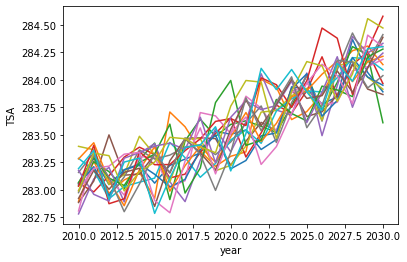

In [13]:
ctrl_lnd_var.weighted(np.cos(np.deg2rad(ctrl_lnd_var.lat))).mean(("lon","lat")).groupby('time.year').mean('time').plot.line(x='year', add_legend=False);

now feedback files

In [14]:
firstyear=2075
lastyear=2095

In [15]:
dsets=[]
for ffs in fdbk_lnd_files:
    df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
    dsets.append(df)
fdbk_lnd_var = xr.concat(dsets,dim=ensdim)

In [16]:
fdbk_lnd_var.time

<xarray.DataArray 'time' (time: 252)>
array([cftime.DatetimeNoLeap(2075, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2075, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2075, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2095, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2095, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2095, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 2075-01-16 12:00:00 ... 2095-12-16 12:00:00
Attributes:
    long_name:  time
    bounds:     time_bounds

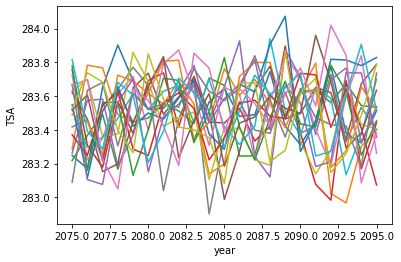

In [17]:
fdbk_lnd_var.weighted(np.cos(np.deg2rad(fdbk_lnd_var.lat))).mean(("lon","lat")).groupby('time.year').mean('time').plot.line(x='year', add_legend=False);

now control end-of-century (note only 3 ensemble members)

In [18]:
firstyear=2075
lastyear=2095

In [19]:
dsets=[]
for ffs in ctrl_lnd_files:
    df = xr.open_mfdataset(ffs, concat_dim=['time'], combine="nested", chunks={'time':360}, parallel=True, preprocess=preprocess)
    dsets.append(df)

# manually subset because only first 3 EMs cover this time period (not sure how to automate this)
nens_red = 3
dsets = dsets[:nens_red]

# new ensemble dim (reduced)
ensdim_red = xr.DataArray(np.array(range(nens_red)), dims='ens', name='ens')
rcp_lnd_var = xr.concat(dsets,dim=ensdim_red)
rcp_lnd_var

<xarray.DataArray 'TSA' (ens: 3, time: 252, lat: 192, lon: 288)>
dask.array<concatenate, shape=(3, 252, 192, 288), dtype=float32, chunksize=(1, 120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2075-01-16 12:00:00 ... 2095-12-16 12:00:00
  * ens      (ens) int64 0 1 2
Attributes:
    units:         K
    long_name:     2m air temperature
    cell_methods:  time: mean

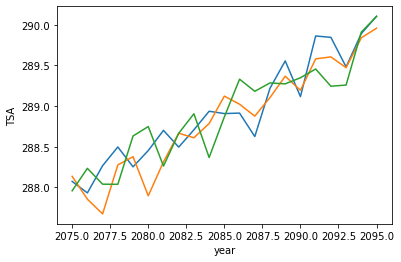

In [20]:
rcp_lnd_var.weighted(np.cos(np.deg2rad(rcp_lnd_var.lat))).mean(("lon","lat")).groupby('time.year').mean('time').plot.line(x='year', add_legend=False);

### Various methods for calculating spatial (lat/lon) gradients

In [ ]:
# np.gradient
# not using spherical harmonics?
npgrad_lat, npgrad_lon = np.gradient(ctrl_lnd_var.TSA, axis=(1,2))
plt.contourf(npgrad_lat[0,:,:], cmap="seismic")
#plt.contourf(npgrad_lon[0,:,:])
plt.colorbar()
# not sure how to interpret the units here - how does it deal with grid spacing?

In [ ]:
# windspharm uses spherical harmonics
# fake the u,v winds? need global data (no missing values)
u = xr.ones_like(ctrl_atm_var.TS)
v = xr.ones_like(ctrl_atm_var.TS)

In [ ]:
# this doesn't like the CESM fixed grid (see Zulip discussion)
w = VectorWind(u, v)

In [ ]:
# this is how to calculate gradient from VectorWind object once that is instantiated
ugrad, vgrad = w.gradient(ctrl_atm_var.TS)

In [ ]:
# metpy gradient
# also not using spherical harmonics? but works with land-only data
# doesn't work when decode_times=False
grad_lat, grad_lon = mpcalc.gradient(ctrl_lnd_var, axes=['lat','lon'])

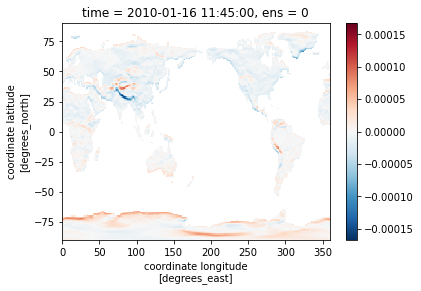

In [135]:
# looks right!
grad_lat[0,0,:,:].plot();
#grad_lon[0,0,:,:].plot();

In [20]:
# pull the units back into xarray
var_ctrl_grad_lat = grad_lat.metpy.dequantify()
var_ctrl_grad_lon = grad_lon.metpy.dequantify()

In [21]:
# convert from K/m to K/km
var_ctrl_grad_lat = var_ctrl_grad_lat * 1000
var_ctrl_grad_lat.attrs["units"] = 'kelvin / kilometer'
var_ctrl_grad_lon = var_ctrl_grad_lon * 1000
var_ctrl_grad_lon.attrs["units"] = 'kelvin / kilometer'

### Slope by average maximum technique (Loarie et al. 2009)

In [22]:
var_ctrl_grad = np.sqrt((var_ctrl_grad_lat)**2 + (var_ctrl_grad_lon)**2)
var_ctrl_grad.attrs["units"] = 'kelvin / kilometer'

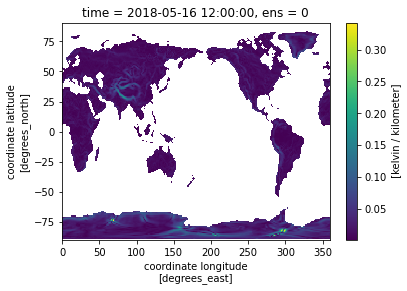

In [27]:
# how much does it change over time? is taking the mean adequate?
var_ctrl_grad[0,100,:,:].plot()

In [23]:
var_ctrl_grad_mean = var_ctrl_grad.mean('time')
var_ctrl_grad_mean.attrs["units"] = 'kelvin / kilometer'

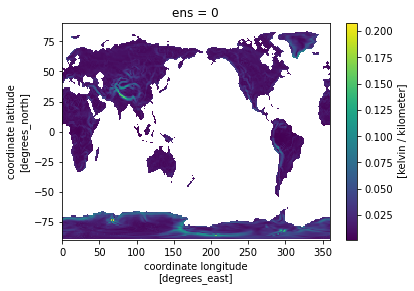

In [143]:
var_ctrl_grad_mean.sel(ens=0).plot();

### Regression/trends

In [193]:
xr.__version__

'0.17.0'

In [199]:
# base timeunits are nanoseconds(!)
ctrl_lnd_var.time[-1]-ctrl_lnd_var.time[0]

<xarray.DataArray 'time' ()>
array(659578500000000000, dtype='timedelta64[ns]')

In [165]:
rc = ctrl_lnd_var.polyfit(dim='time', deg=1)

In [167]:
rc

,Array,Chunk
Bytes,16.88 MiB,864.00 kiB
Shape,"(2, 20, 192, 288)","(2, 1, 192, 288)"
Count,477 Tasks,20 Chunks
Type,float64,numpy.ndarray


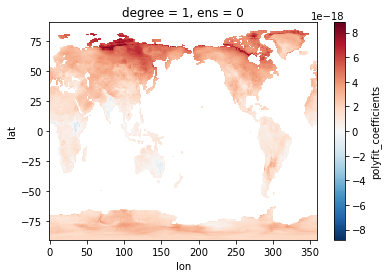

In [195]:
# first coefficient will be highest degree
rc.polyfit_coefficients.sel(ens=0)[0].plot();

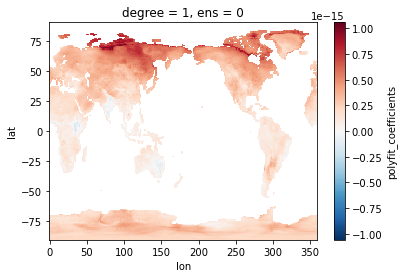

In [153]:
# convert to C/decade assuming base units are C/month - still seems too small? what are the base time units?
(rc.polyfit_coefficients.sel(ens=0)[0]*12*10).plot();
# with decode_times=False, base units might be days, estimate 30 days/month
#(rc.polyfit_coefficients[0]*30*120).plot()
# this looks better

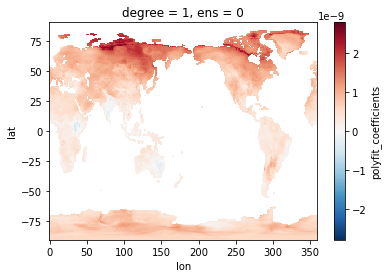

In [168]:
# assume the base units are in seconds, convert to C/decade (no leap) - still too small? but the spatial pattern looks ok
(rc.polyfit_coefficients.sel(ens=0)[0]*60*60*24*365*10).plot();

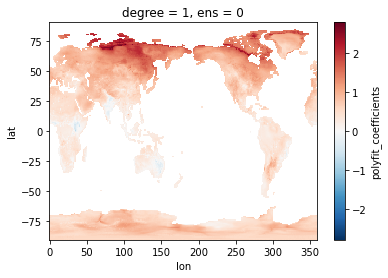

In [201]:
# based on quick time diff above - the base units might be nanoseconds!
(rc.polyfit_coefficients.sel(ens=0)[0]*10**9*60*60*24*365*10).plot();

In [203]:
var_ctrl_reg = rc.polyfit_coefficients[0]*10**9*60*60*24*365*10
var_ctrl_reg.attrs["units"] = "K/decade"

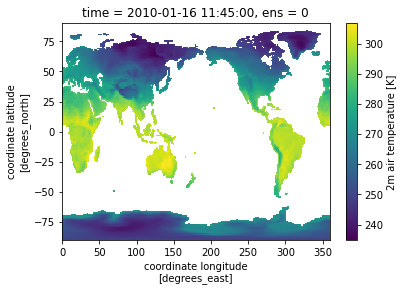

In [154]:
# sanity check T (K) first time point
ctrl_lnd_var.sel(ens=0).isel(time=0).plot();

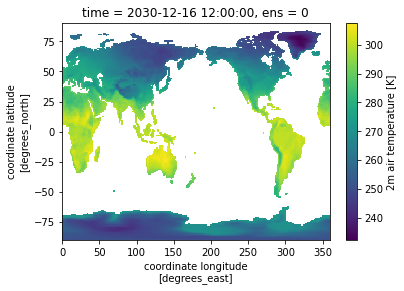

In [155]:
# last time point
ctrl_lnd_var.sel(ens=0).isel(time=-1).plot()

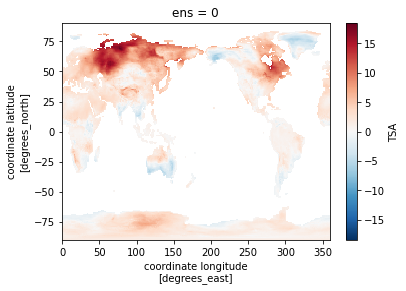

In [156]:
# difference
(ctrl_lnd_var.sel(ens=0).isel(time=-1)-ctrl_lnd_var.sel(ens=0).isel(time=0)).plot()

In [162]:
# quick global (weighted) mean difference - note this is the last month relative to the first month so difference will be larger than annual mean diff
(ctrl_lnd_var.sel(ens=0).isel(time=-1)-ctrl_lnd_var.sel(ens=0).isel(time=0)).weighted(np.cos(np.deg2rad(ctrl_lnd_var.lat))).mean(("lon","lat")).load()

<xarray.DataArray 'TSA' ()>
array(2.4105008, dtype=float32)
Coordinates:
    ens      int64 0

In [174]:
# try with np.polyfit
# workaround https://stackoverflow.com/questions/38960903/applying-numpy-polyfit-to-xarray-dataset
months = len(ctrl_lnd_var.time)
times = np.arange(0,months)+1
times

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [175]:
# define a function to compute a linear trend of a timeseries
# here use the times array instead of pulling time from the data array
def linear_trend(x):
    pf = np.polyfit(times, x, 1)
    # need to return an xr.DataArray for groupby
    return xr.DataArray(pf[0])

In [176]:
# stack lat and lon into a single dimension called allpoints
stacked = ctrl_lnd_var.stack(allpoints=['lat','lon'])

In [183]:
stacked

<xarray.DataArray 'TSA' (ens: 20, time: 252, allpoints: 55296)>
dask.array<reshape, shape=(20, 252, 55296), dtype=float32, chunksize=(1, 120, 55296), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 2010-01-16 11:45:00 ... 2030-12-16 12:00:00
  * ens        (ens) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * allpoints  (allpoints) MultiIndex
  - lat        (allpoints) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0
  - lon        (allpoints) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Attributes:
    units:         K
    long_name:     2m air temperature
    cell_methods:  time: mean

In [191]:
stacked.sel(ens=0).groupby('allpoints')

DataArrayGroupBy, grouped over 'allpoints' 
55296 groups with labels (-90.0,, 0.0), ..., (90.0,, 358....

In [ ]:
# This is now painfully slow even for a single ensemble member...either fix this implementation or go back to xarray.polyfit
# apply the function over allpoints to calculate the trend at each point
# do this separately for each ensemble member
for e in range(nens):
    trend = stacked.sel(ens=e).groupby('allpoints').apply(linear_trend)
    # unstack back to lat lon coordinates
    trend_unstacked = trend.unstack('allpoints')
    # convert to K/decade
    var_ctrl_reg[e] = trend_unstacked*12*10
    
var_ctrl_reg.attrs["units"] = "K/decade"

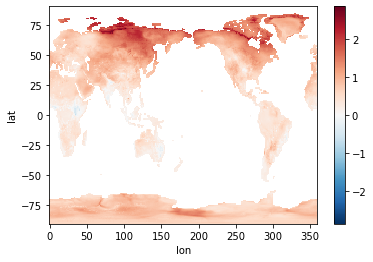

In [55]:
# quick plot converting from K/month to K/decade
(trend_unstacked*120).plot()

In [56]:
var_ctrl_reg = trend_unstacked*120
var_ctrl_reg.attrs["units"] = "K/decade"

In [57]:
# change over 20 years or 240 months (to compare with above)
trend_unstacked.weighted(np.cos(np.deg2rad(da.lat))).mean(("lon","lat"))*240

<xarray.DataArray ()>
array(1.33285624)

### Climate velocity

In [202]:
var_ctrl_grad_mean # K/km

<xarray.DataArray (ens: 20, lat: 192, lon: 288)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.02557636, 0.01272454, 0.0133567 , ..., 0.01189738,
         0.01229876, 0.01505631],
        [0.01635813, 0.01536914, 0.01558249, ..., 0.01420571,
         0.01482554, 0.01661388],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.03165176, 0.01296238, 0.01509744, ..., 0.01190854,
         0.01244259, 0.01608705],
        [0.0173594 , 0.0161125 , 0.01676345, ..., 0.01463818,
         0.01485759, 0.01613971],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [0.02808793, 0.0130367 , 0.01391292, ..., 0.01151829,
         0.01224899, 0.01528991],
        [0.01753986, 0.01540118, 0.01610047, ..., 0.01445342,
         0.01496269, 0.01777395],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Attributes:
    units:    kelvin / kilometer

In [205]:
var_ctrl_reg # K/decade

<xarray.DataArray 'polyfit_coefficients' (ens: 20, lat: 192, lon: 288)>
dask.array<mul, shape=(20, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
    degree   int64 1
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    units:    K/decade

In [206]:
var_ctrl_cV = var_ctrl_reg/var_ctrl_grad_mean
var_ctrl_cV.attrs["units"] = 'km/decade'

In [207]:
var_ctrl_cV

<xarray.DataArray (ens: 20, lat: 192, lon: 288)>
dask.array<truediv, shape=(20, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
    degree   int64 1
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Attributes:
    units:    km/decade

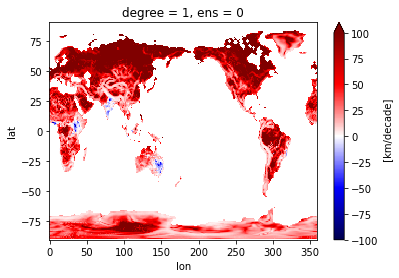

In [208]:
# first ensemble member
var_ctrl_cV.sel(ens=0).plot(vmin=-100,vmax=100, cmap='seismic')

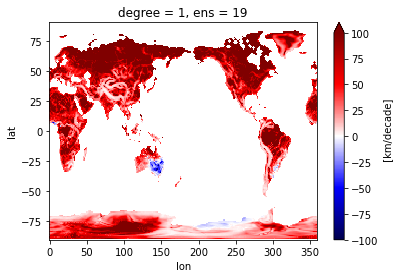

In [214]:
# last ensemble member
var_ctrl_cV.sel(ens=19).plot(vmin=-100,vmax=100, cmap='seismic')

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


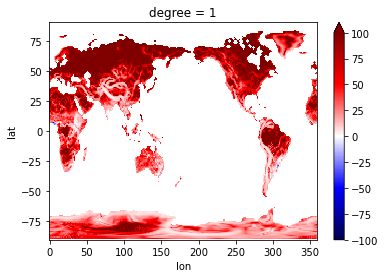

In [210]:
# ensemble mean
var_ctrl_cV.mean(dim='ens').plot(vmin=-100,vmax=100, cmap='seismic')

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


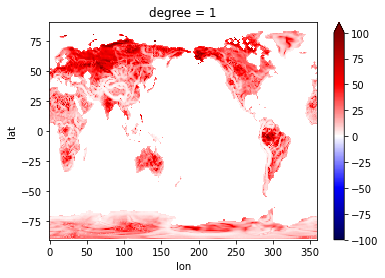

In [213]:
# ensemble variance
var_ctrl_cV.std(dim='ens').plot(vmin=-100,vmax=100, cmap='seismic')

## Function to calculate climate velocity
To Do: this is a slow workflow, incorporate dask?

In [21]:
ctrl_lnd_var

<xarray.DataArray 'TSA' (ens: 20, time: 252, lat: 192, lon: 288)>
dask.array<concatenate, shape=(20, 252, 192, 288), dtype=float32, chunksize=(1, 120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2010-01-16 11:45:00 ... 2030-12-16 12:00:00
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Attributes:
    units:         K
    long_name:     2m air temperature
    cell_methods:  time: mean

In [22]:
fdbk_lnd_var

<xarray.DataArray 'TSA' (ens: 20, time: 252, lat: 192, lon: 288)>
dask.array<concatenate, shape=(20, 252, 192, 288), dtype=float32, chunksize=(1, 120, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2075-01-16 12:00:00 ... 2095-12-16 12:00:00
  * ens      (ens) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Attributes:
    units:         K
    long_name:     2m air temperature
    cell_methods:  time: mean

In [25]:
# function to calculate climate velocity given temperature data array
def climate_velocity(da):
    
    # calculate spatial gradients using metpy
    mp_grad_lat, mp_grad_lon = mpcalc.gradient(da, axes=['lat','lon'])
    
    # pull the units back into xarray
    grad_lat = mp_grad_lat.metpy.dequantify()
    grad_lon = mp_grad_lon.metpy.dequantify()
    
    # assuming T in Kelvin, convert from K/m to K/km
    grad_lat = grad_lat * 1000
    grad_lat.attrs["units"] = 'kelvin / kilometer'
    grad_lon = grad_lon * 1000
    grad_lon.attrs["units"] = 'kelvin / kilometer'
    
    # Slope by average maximum technique (Loarie et al. 2009)
    grad = np.sqrt((grad_lat)**2 + (grad_lon)**2)
    grad.attrs["units"] = 'kelvin / kilometer'
    # average over time - is this adequate?
    grad_mean = grad.mean('time')
    grad_mean.attrs["units"] = 'kelvin / kilometer'
    
    # regression via polyfit
    rc = da.polyfit(dim='time', deg=1)
    
    # convert from K/nanosecond to K/decade
    reg = rc.polyfit_coefficients[0]*10**9*60*60*24*365*10
    reg.attrs["units"] = "K/decade"
    
    # climate velocity = temporal / spatial gradients
    cV = reg/grad_mean
    cV.attrs["units"] = 'km/decade'
    
    return(cV)   

In [26]:
# warnings likely due to missing values over non-land points
ctrl_cV = climate_velocity(ctrl_lnd_var)

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_div

In [ ]:
# ensemble mean quick plot
ctrl_cV.mean(dim='ens').plot(vmin=-100,vmax=100, cmap='seismic')

In [27]:
fdbk_cV = climate_velocity(fdbk_lnd_var)

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_div

In [ ]:
# ensemble mean quick plot
fdbk_cV.mean(dim='ens').plot(vmin=-100,vmax=100, cmap='seismic')

In [28]:
rcp_cV = climate_velocity(rcp_lnd_var)

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/pint/quantity.py:1237: RuntimeWarning: invalid value encountered in true_div

In [ ]:
# ensemble mean quick plot
rcp_cV.mean(dim='ens').plot(vmin=-100,vmax=100, cmap='seismic')

### Comparison plots

In [29]:
cVmaps = [ctrl_cV, fdbk_cV, rcp_cV]
nsim = len(cVmaps)
simnames = ['Control, 2010-2030', 'Feedback, 2075-2095', 'Control, 2075-2095']
typenames = ['Ensemble Mean', 'Standard Deviation']

/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/kdagon/miniconda/envs/GLENS/lib/python3.7/site-packages/dask/ar

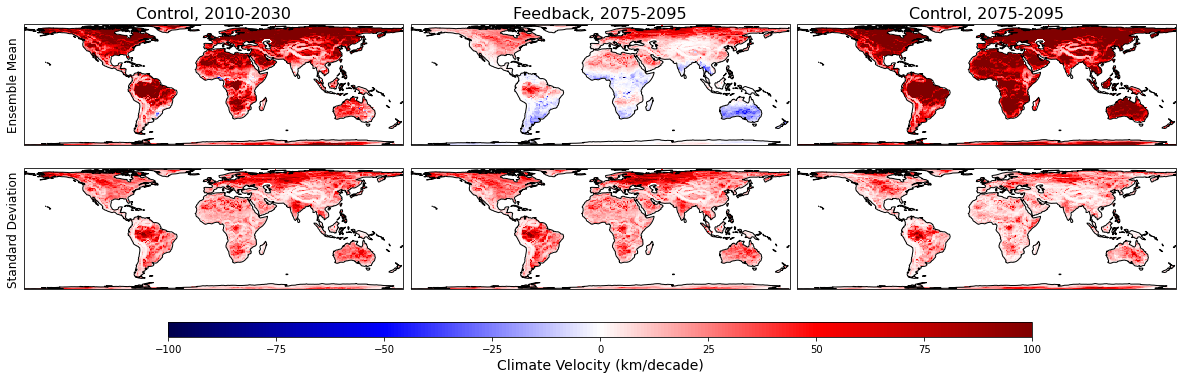

In [34]:
fig, axs = plt.subplots(2, nsim, figsize=(20, 10), subplot_kw={'projection': ccrs.LambertCylindrical()})

for j in range(nsim):
    
    for i in range(2):
        
        if i==0:
            # ensemble mean
            cV = cVmaps[j].mean(dim='ens')
        else:
            # ensemble variance
            cV = cVmaps[j].std(dim='ens')
    
        field, lon = add_cyclic_point(cV, coord=cV.lon)
        lat = cV.lat   
        cf = axs[i,j].pcolormesh(lon, lat, field, cmap='seismic',transform=ccrs.PlateCarree(), vmin=-100, vmax=100)
        axs[i,j].coastlines()
        axs[i,j].set_global()
        
        # simulation label on first row only
        if i==0:
            axs[i,j].set_title(simnames[j], fontsize=16)
        
        # analysis type label on first column only
        if j==0:
            axs[i,j].set_ylabel(typenames[i], fontsize=12)
            axs[i,j].set_yticks([])


# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9, wspace=0.02, hspace=-0.6)
#plt.subplots_adjust(hspace=-0.5,wspace=0.1)
# Set height padding for plots
#fig.set_constrained_layout_pads(w_pad=0., h_pad=0.1, hspace=0., wspace=0.)

# Why do I have to move the colorbar up?
cb_ax = fig.add_axes([0.2, 0.3, 0.6, 0.02])
cmap = mpl.cm.seismic
norm = mpl.colors.Normalize(vmin=-100, vmax=100)
cb1 = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm, orientation='horizontal')
cb1.ax.set_xlabel('Climate Velocity (km/decade)', fontsize=14)

#plt.savefig("cV_ctrl_fdbk_mean_std.png")